# Multiple Rectangles Detection

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
%matplotlib inline

## Data Generation

In [11]:
num_imgs = 60000

img_size = 10
min_rect_size = 2
max_rect_size = 5
num_objects = 3

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        width, height = np.random.randint(min_rect_size, max_rect_size, size = 2)
        x = np.random.randint(0, img_size - width)
        y = np.random.randint(0, img_size - height)
        imgs[i_img, x:x + width, y:y + height] = 1.
        bboxes[i_img, i_object] = [x, y, width, height]

imgs.shape, bboxes.shape

((60000, 10, 10), (60000, 3, 4))

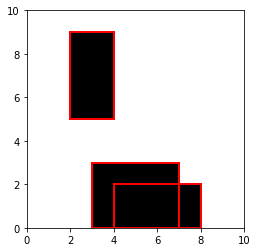

In [3]:
i = 5
plt.imshow(imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], lw = 2, ec = 'r', fc = 'none'))
plt.savefig('multiple-rectangles_data.png', dpi = 100)

## Preprocessing

In [12]:
# Reshape and normalize the data to mean 0 and std 1.
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((60000, 100), -2.484471887479837e-17, 1.0)

In [13]:
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape

(60000, 12)

## Train Test Split

In [14]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## Model

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.models import load_model
model = Sequential([
        Dense(256, input_dim = X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.6), 
        Dense(y.shape[-1])
    ])
model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               25856     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                3084      
Total params: 28,940
Trainable params: 28,940
Non-trainable params: 0
_________________________________________________________________


## IoU Calculating Function

In [16]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

## Distance Calculating function

In [17]:
def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

## Training

In [18]:
from itertools import permutations
num_epochs = 50
fact = math.factorial(num_objects)

switched_train_y = np.array(train_y)
switched = np.zeros((len(switched_train_y), num_epochs))
ious_epochs = np.zeros((len(switched_train_y), num_epochs))
dists_epochs = np.zeros((len(switched_train_y), num_epochs))
mses_epochs = np.zeros((len(switched_train_y), num_epochs))

for epoch in range(num_epochs):
    print('Epoch ', epoch)
    model.fit(train_X, switched_train_y, epochs = 1, validation_data = (test_X, test_y), verbose = 1, 
              callbacks = [ModelCheckpoint('Multiple_Rectangles_model.h5', 
                                           monitor = 'val_loss',
                                           save_best_only = True)])
    pred_y = model.predict(train_X)
    
    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, switched_train_y)):
        
        pred_bboxes = pred_bboxes.reshape(num_objects, -1)
        exp_bboxes = exp_bboxes.reshape(num_objects, -1)
        
        p_exp_bboxes = list(permutations(exp_bboxes))
        ious = np.zeros((fact, num_objects))
        dists = np.zeros((fact, num_objects))
        mses = np.zeros((fact, num_objects))
        p_ious = np.zeros(fact)
        p_mses = np.zeros(fact)
        p_dists = np.zeros(fact)
        
        for j, exp_bboxes in enumerate(p_exp_bboxes):
            exp_bboxes = list(exp_bboxes) 
            for k in range(num_objects):
                ious[j, k] = IOU(exp_bboxes[k], pred_bboxes[k])
                dists[j, k] = distance(exp_bboxes[k], pred_bboxes[k])
                mses[j, k] = np.mean(np.square(exp_bboxes[k] - pred_bboxes[k]))
            p_ious[j] = sum(ious[j, :])
            p_dists[j] = sum(dists[j, :])
            p_mses[j] = sum(mses[j, :])
            
        keymax = p_ious.argmax()
        ious_epochs[i, epoch] += p_ious[keymax] / num_objects
        dists_epochs[i, epoch] += p_dists[keymax] / num_objects
        mses_epochs[i, epoch] += p_mses[keymax] / num_objects
        
        switched_train_y[i] = np.array(p_exp_bboxes[keymax]).flatten()
        if keymax != 0:
            switched[i, epoch] = 1.
    
    print('Switched {} % of all elements'.format(np.mean(switched[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_epochs[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_epochs[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_epochs[:, epoch])))

Epoch  0
1500/1500 [==============================] - 1s 883us/step - loss: 0.0506 - val_loss: 0.0193
Switched 81.11041666666667 % of all elements
Mean IOU: 0.1788553277502246
Mean dist: 0.2266466977372695
Mean mse: 0.018633963872696162
Epoch  1
1500/1500 [==============================] - 1s 847us/step - loss: 0.0190 - val_loss: 0.0197
Switched 51.03333333333333 % of all elements
Mean IOU: 0.2284130780107691
Mean dist: 0.19944021532773962
Mean mse: 0.015596832524519587
Epoch  2
1500/1500 [==============================] - 1s 903us/step - loss: 0.0159 - val_loss: 0.0219
Switched 35.31458333333333 % of all elements
Mean IOU: 0.30824813344678287
Mean dist: 0.16333723108088216
Mean mse: 0.011998930992022564
Epoch  3
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0131 - val_loss: 0.0244
Switched 21.122916666666665 % of all elements
Mean IOU: 0.37471640558568187
Mean dist: 0.1330088873768464
Mean mse: 0.009328753664075191
Epoch  4
1500/1500 [=============================

1500/1500 [==============================] - 1s 868us/step - loss: 0.0085 - val_loss: 0.0273
Switched 6.79375 % of all elements
Mean IOU: 0.4631465986574121
Mean dist: 0.09794288360092568
Mean mse: 0.006208275456729079
Epoch  36
1500/1500 [==============================] - 1s 857us/step - loss: 0.0085 - val_loss: 0.0266
Switched 6.875000000000001 % of all elements
Mean IOU: 0.46870230236502386
Mean dist: 0.09706270682308427
Mean mse: 0.006175470682087787
Epoch  37
1500/1500 [==============================] - 1s 830us/step - loss: 0.0086 - val_loss: 0.0265
Switched 7.187499999999999 % of all elements
Mean IOU: 0.46743953281863937
Mean dist: 0.09796915322370638
Mean mse: 0.0061337921773013055
Epoch  38
1500/1500 [==============================] - 1s 833us/step - loss: 0.0085 - val_loss: 0.0270
Switched 6.6083333333333325 % of all elements
Mean IOU: 0.46180806904197885
Mean dist: 0.09918265611084173
Mean mse: 0.006282938315217732
Epoch  39
1500/1500 [==============================] - 1s 8

## Switching Track

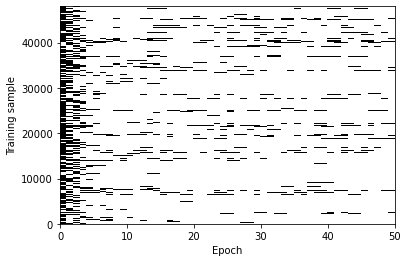

In [19]:
# Show switchings for a few training samples.
plt.pcolormesh(switched[:, :], cmap = 'Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')
plt.savefig('multiple-rectangles_switches.png', dpi = 100)
plt.show()

## Metrics Track

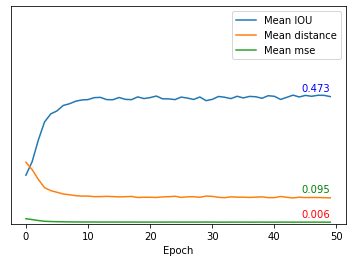

In [20]:
# Plot metrics on the training data.
mean_ious_epoch = np.mean(ious_epochs, axis = 0)
mean_dists_epoch = np.mean(dists_epochs, axis = 0)
mean_mses_epoch = np.mean(mses_epochs, axis = 0)
plt.plot(mean_ious_epoch, label = 'Mean IOU')  # between predicted and assigned true bboxes
plt.plot(mean_dists_epoch, label = 'Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, label = 'Mean mse')
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch) - 1, mean_ious_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'b')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch) - 1, mean_dists_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch) - 1, mean_mses_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'r')

plt.xlabel('Epoch')
# Hide y tick
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

plt.legend()
plt.ylim(0, 0.8)
plt.savefig('training_metrics.png', dpi = 100)

## Denormalize Data

In [21]:
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(12000, 3, 4)

## Visualize Results

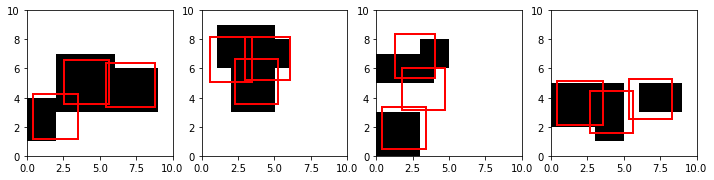

In [22]:
plt.figure(figsize = (12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], lw = 2, ec = 'r', fc = 'none'))
        # TODO: Calculate max IOU with all expected bounding boxes.
#         plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.4), color='r')

plt.savefig('multiple-rectangles_with-switching.png', dpi = 100)

## Overall Assessment

In [23]:
from keras.models import load_model
from itertools import permutations
fact = math.factorial(num_objects)
model_test = load_model('Multiple_Rectangles_model.h5')
pred_y = model_test.predict(test_X)
sum_iou = 0.
sum_dist = 0.
sum_mse = 0.
test_y = np.array(test_y)

for pred_bboxes, test_bboxes in zip(pred_y, test_y):
    
    pred_bboxes = pred_bboxes.reshape(num_objects, -1)
    test_bboxes = test_bboxes.reshape(num_objects, -1)
    
    p_test_bboxes = list(permutations(test_bboxes))
    p_ious = np.zeros(fact)
    p_dists = np.zeros(fact)
    p_mses = np.zeros(fact)
    ious = np.zeros((fact, num_objects))
    dists = np.zeros((fact, num_objects))
    mses = np.zeros((fact, num_objects))
    
    for j, test_bboxes in enumerate(p_test_bboxes):
        test_bboxes = list(test_bboxes) 
        for k in range(num_objects):
            ious[j, k] = IOU(test_bboxes[k], pred_bboxes[k])
            dists[j, k] = distance(test_bboxes[k], pred_bboxes[k])
            mses[j, k] = np.mean(np.square(test_bboxes[k] - pred_bboxes[k]))
        p_ious[j] = sum(ious[j, :])
        p_dists[j] = sum(dists[j, :])
        p_mses[j] = sum(mses[j, :])
            
    keymax = p_ious.argmax()
    sum_iou += p_ious[keymax] 
    sum_dist += p_dists[keymax] 
    sum_mse += p_mses[keymax] 

mean_iou = sum_iou / (num_objects * len(pred_y))
mean_dist = sum_dist / (num_objects * len(pred_y))
mean_mse = sum_mse / (num_objects * len(pred_y))
print('IoU:', mean_iou)
print('Distance:', mean_dist)
print('MSE:', mean_mse)

IoU: 0.4654082235451728
Distance: 0.09664215779995443
MSE: 0.0061412154516344635
